In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread
from skimage.color import rgb2gray
import gdown

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1YwT0FNTaZgJjUtvzSHOcIsbWfa2fs9eM', 'bridge.jpg', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1YwT0FNTaZgJjUtvzSHOcIsbWfa2fs9eM
To: /content/bridge.jpg
100%|██████████| 306k/306k [00:00<00:00, 73.6MB/s]


'bridge.jpg'

## Background - Fourier Series

The Fourier Transform is a mathematical tool used to decompose a signal into its frequency components. In the case of image processing, the Fourier Transform can be used to analyze the frequency content of an image, which can be useful for tasks such as image filtering and feature extraction. He stated that any periodic function could be expressed as a sum of infinite sines and cosines:

$
f(x) = \frac{a_0}{2} + \sum_{n=1}^\infty a_n \cos(nx) + \sum_{n=1}^\infty b_n \sin(nx)
$

[More detail about the formula here](#)

Fourier Transform is a generalization of the complex Fourier Series. In image processing, we use the discrete 2D Fourier Transform with formulas:

$
f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u, v) \cdot e^{i 2 \pi \left( \frac{xu}{M} + \frac{yv}{N} \right)}
$

$
F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-i 2 \pi \left( \frac{xu}{M} + \frac{yv}{N} \right)}
$


In [ ]:
fil_path = '/content'  # Base directory path for image files
imgbridge = 'bridge.jpg'  # Filename of the bridge image

In [ ]:
def ShowImage(ImageList, nRows=1, nCols=2, WidthSpace=0.00, HeightSpace=0.00):
    """
    Display a list of images in a grid layout using Matplotlib.

    Parameters:
        ImageList (list): List of images to be displayed.
        nRows (int): Number of rows in the grid layout. Default is 1.
        nCols (int): Number of columns in the grid layout. Default is 2.
        WidthSpace (float): Horizontal space between grid cells. Default is 0.00.
        HeightSpace (float): Vertical space between grid cells. Default is 0.00.
    """
    # Initialize a GridSpec object for the grid layout with specified rows and columns
    gs = gridspec.GridSpec(nRows, nCols)

    # Update the grid spacing with the provided width and height spacing
    gs.update(wspace=WidthSpace, hspace=HeightSpace)  # Adjust spacing between plots.

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Loop through the list of images
    for i in range(len(ImageList)):
        # Create a subplot for the current image using GridSpec
        ax1 = plt.subplot(gs[i])

        # Remove tick labels for a cleaner display
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        # Set the aspect ratio to 'equal' to preserve image dimensions
        ax1.set_aspect('equal')

        # Create another subplot using standard indexing
        plt.subplot(nRows, nCols, i + 1)

        # Copy the image to avoid modifying the original
        image = ImageList[i].copy()

        # Check if the image is grayscale (2D array)
        if len(image.shape) < 3:
            # Display grayscale image using the appropriate colormap
            plt.imshow(image, plt.cm.gray)
        else:
            # Display color image
            plt.imshow(image)

        # Add a title to the image, e.g., "Image 0", "Image 1", etc.
        plt.title("Image " + str(i))

        # Turn off axes for a cleaner display
        plt.axis('off')

    # Show all the images
    plt.show()


In [ ]:
def Image3Dto2D(image):
    """
    Convert a 3D image (color) to a 2D image (grayscale).

    Parameters:
        image (ndarray): Input image, which can be 2D (grayscale) or 3D (color).

    Returns:
        image_2D (ndarray): Grayscale image as a 2D array.
    """
    # Check if the image has at least 3 dimensions (color image)
    if len(image.shape) >= 3:
        # Convert the 3D color image to grayscale using OpenCV's cvtColor function
        image_2D = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is already 2D (grayscale), create a copy of it
        image_2D = image.copy()

    return image_2D


In [ ]:
def DFT_Transformation(image):
    """
    Perform Discrete Fourier Transform (DFT) on an image and compute its magnitude spectrum.

    Parameters:
        image (ndarray): Input image, can be 2D (grayscale) or 3D (color).

    Returns:
        magnitude_spectrum (ndarray): The magnitude spectrum of the transformed image.
        dft_shift (ndarray): The shifted DFT result (frequency domain representation).
    """
    # Convert the image to 2D grayscale if it is a color image
    img = Image3Dto2D(image)

    # Convert the image to float32 format (required for DFT)
    img_float32 = np.float32(img)

    # Apply Discrete Fourier Transform (DFT) to the image
    dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero-frequency component to the center of the frequency domain
    dft_shift = np.fft.fftshift(dft)

    # Compute the magnitude spectrum (log-scaled for visualization)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    return magnitude_spectrum, dft_shift


In [ ]:
def ApplyCenterSquareMask1(dft_shift, size,dim):
    """
    Apply a center square mask to the frequency domain representation of an image.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        size (int): Half the side length of the square mask to be applied.

    Returns:
        masked_dft_shift (ndarray): The frequency domain representation after applying the mask.
        mask (ndarray): The mask applied to the frequency domain representation.
    """
    # Get the dimensions of the DFT
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2  # Calculate the center of the frequency domain

    # Create a zero-filled mask with the same size as the frequency domain representation
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Set a center square to 1
    mask[crow - size:crow + size, ccol - size:ccol + size] = 1

    # Apply the mask to the frequency domain representation
    masked_dft_shift = dft_shift * mask[:,:,dim]

    return masked_dft_shift, mask


In [ ]:
def ApplyCenterSquareMask2(dft_shift, size,dim):
    """
    Apply a center square mask to the frequency domain representation of an image.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        size (int): Half the side length of the square mask to be applied.

    Returns:
        masked_dft_shift (ndarray): The frequency domain representation after applying the mask.
        mask (ndarray): The mask applied to the frequency domain representation.
    """
    # Get the dimensions of the DFT
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2  # Calculate the center of the frequency domain

    # Create a zero-filled mask with the same size as the frequency domain representation
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Set a center square to 1
    mask[crow - size:crow + size, ccol - size:ccol + size] = 1
    mask = 1 -mask
    # Apply the mask to the frequency domain representation
    masked_dft_shift = dft_shift * mask[:,:,dim]

    return masked_dft_shift, mask

In [ ]:
def InverseDFTWithMask(dft_shift, mask):
    """
    Apply a mask to the frequency domain representation of an image and perform an inverse DFT.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        mask (ndarray): The mask to apply in the frequency domain.

    Returns:
        image_inverse (ndarray): The reconstructed image in the spatial domain after applying the mask.
    """
    # Apply the mask to the frequency domain representation
    fshift = dft_shift * mask

    # Perform an inverse shift to move the zero-frequency component backv to its original position
    f_ishift = np.fft.ifftshift(fshift)

    # Perform the inverse Discrete Fourier Transform (IDFT)
    img_inverse = cv2.idft(f_ishift)

    # Compute the magnitude of the spatial domain representation
    image_inverse = cv2.magnitude(img_inverse[:, :, 0], img_inverse[:, :, 1])

    return image_inverse


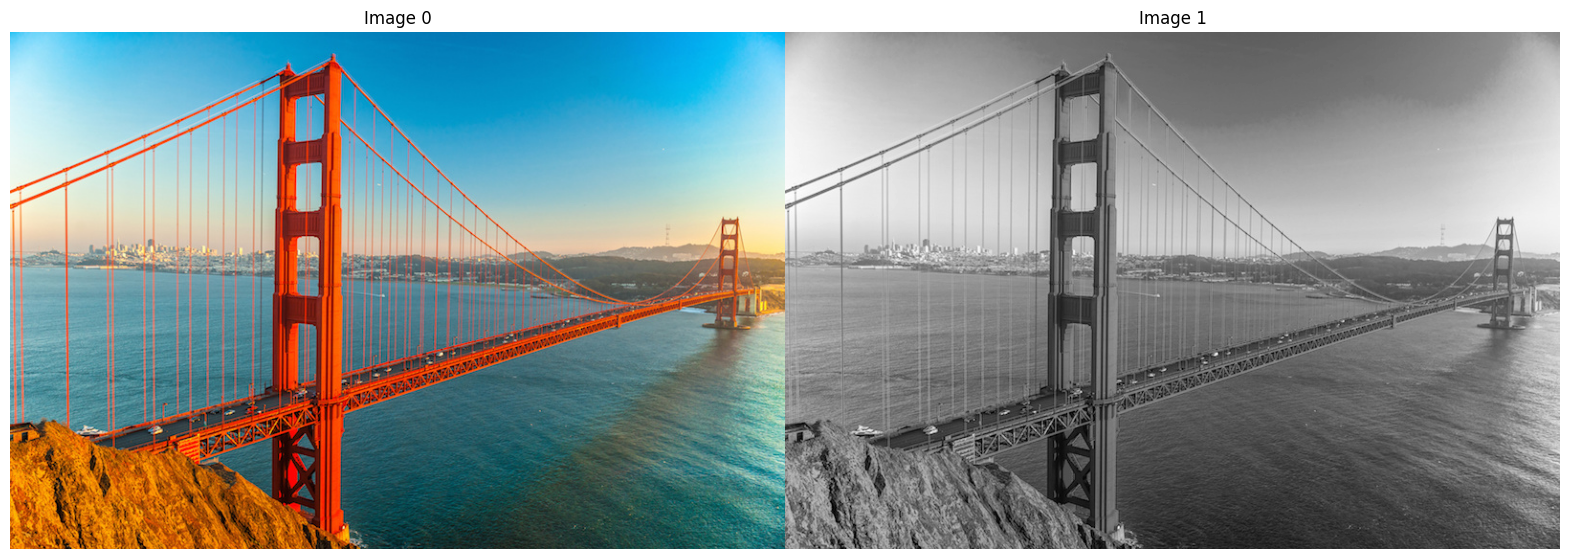

In [ ]:
# Read Image
image_color = imread(imgbridge)
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

# Display Image
ShowImage([image_color, image_gray], 1, 2)

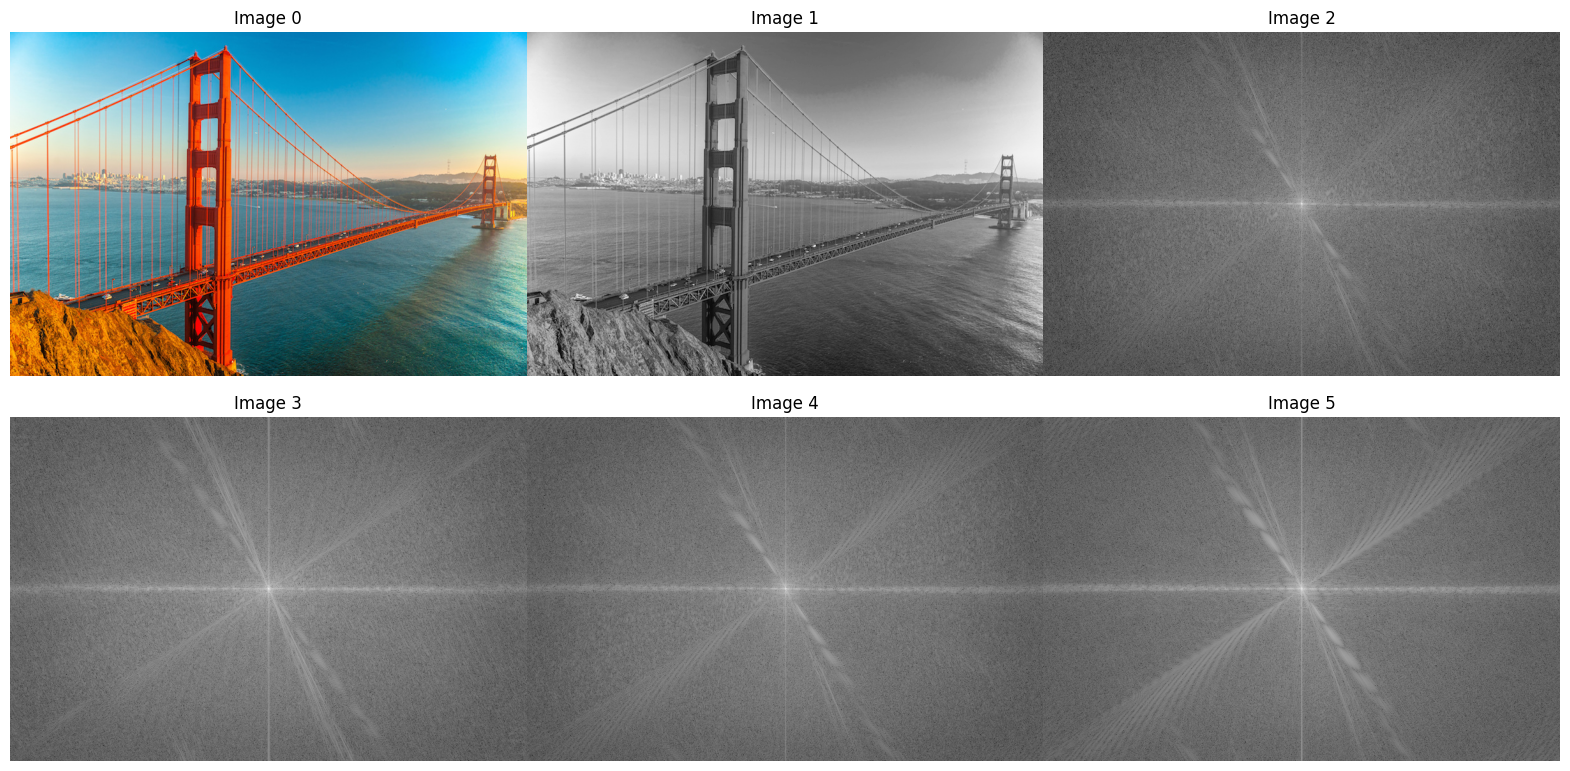

In [ ]:
image_dft_frequency, dft_shift = DFT_Transformation(image_gray)
image_dft_frequency1, dft_shift1 = DFT_Transformation(image_color[:,:,0])
image_dft_frequency2, dft_shift2 = DFT_Transformation(image_color[:,:,1])
image_dft_frequency3, dft_shift3 = DFT_Transformation(image_color[:,:,2])
ShowImage([image_color, image_gray,  image_dft_frequency, image_dft_frequency1, image_dft_frequency2, image_dft_frequency3], 2, 3)

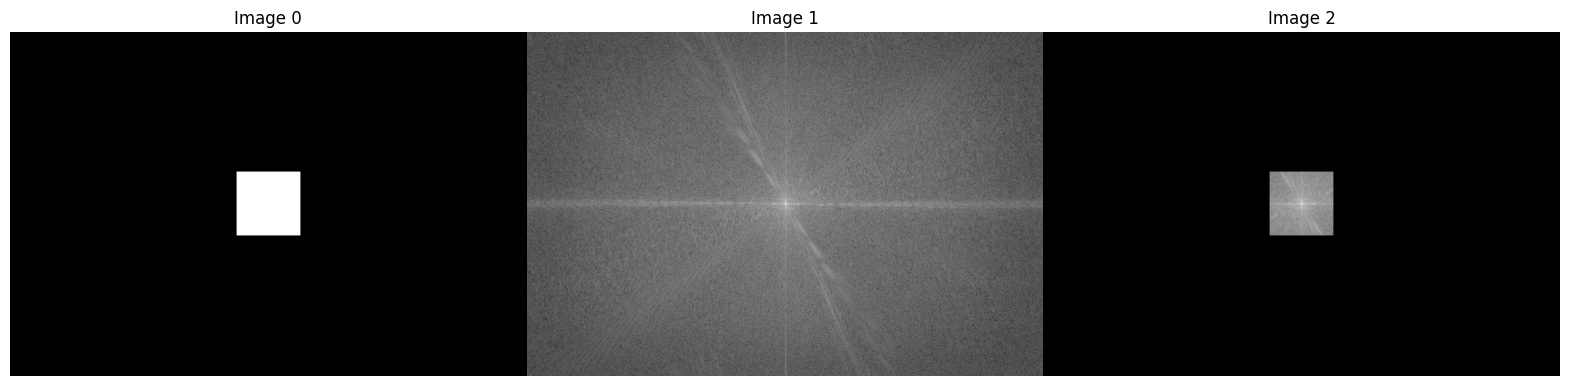

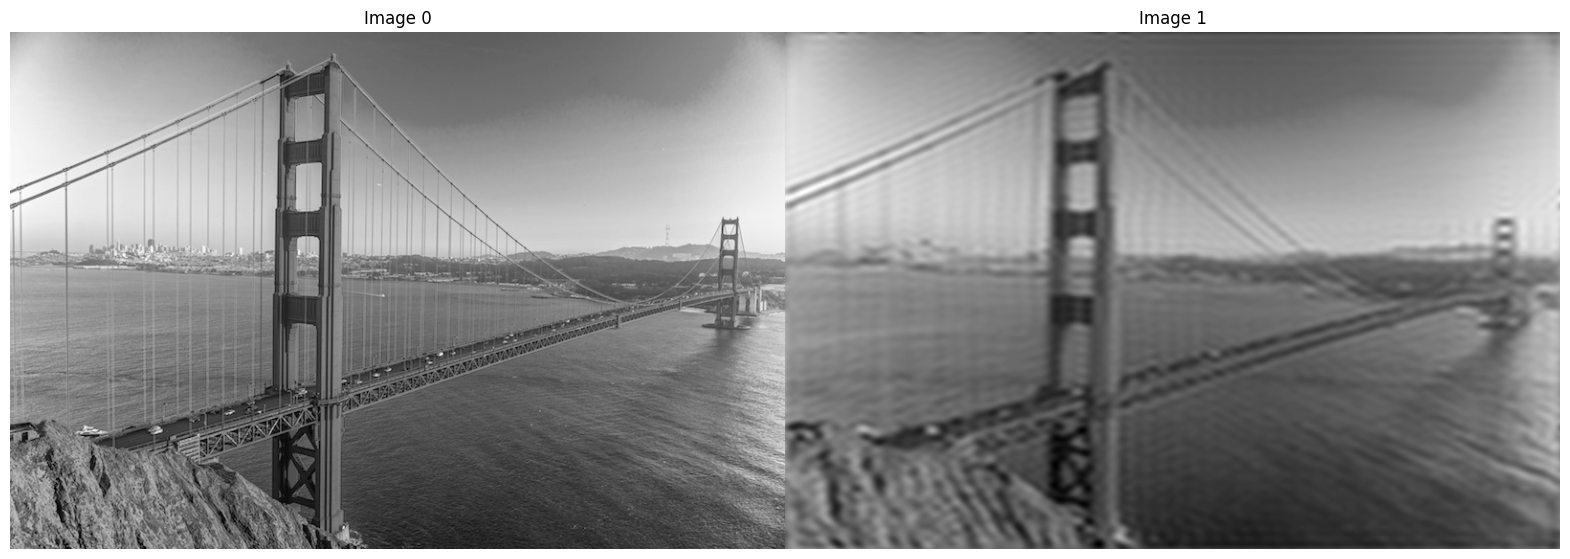

In [ ]:
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros

image_dft_frequency_crop,mask = ApplyCenterSquareMask1(image_dft_frequency,size = 50,dim = 0)

# apply mask and inverse DFT

image_inverse = InverseDFTWithMask(dft_shift, mask)

ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

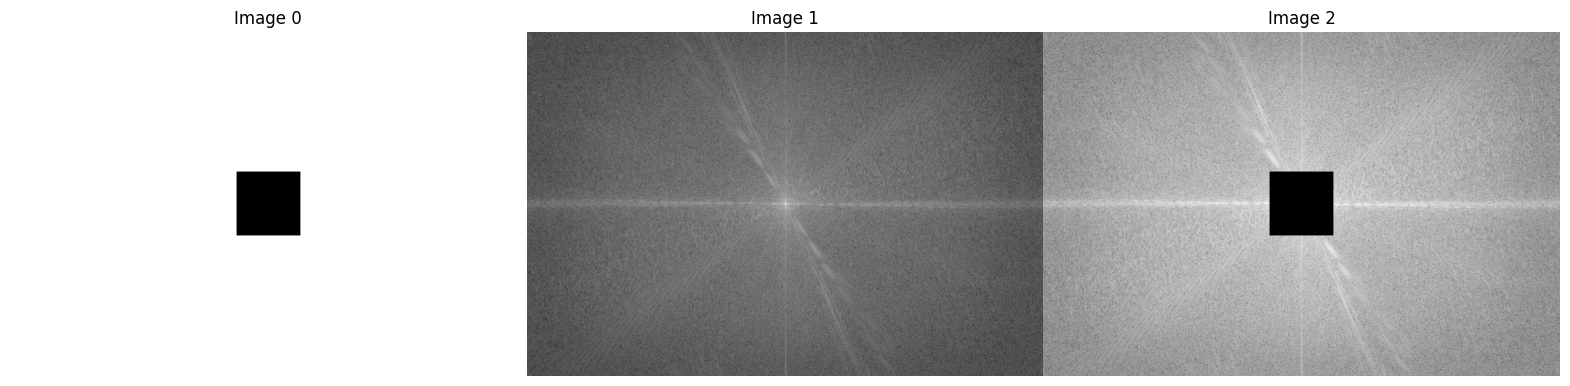

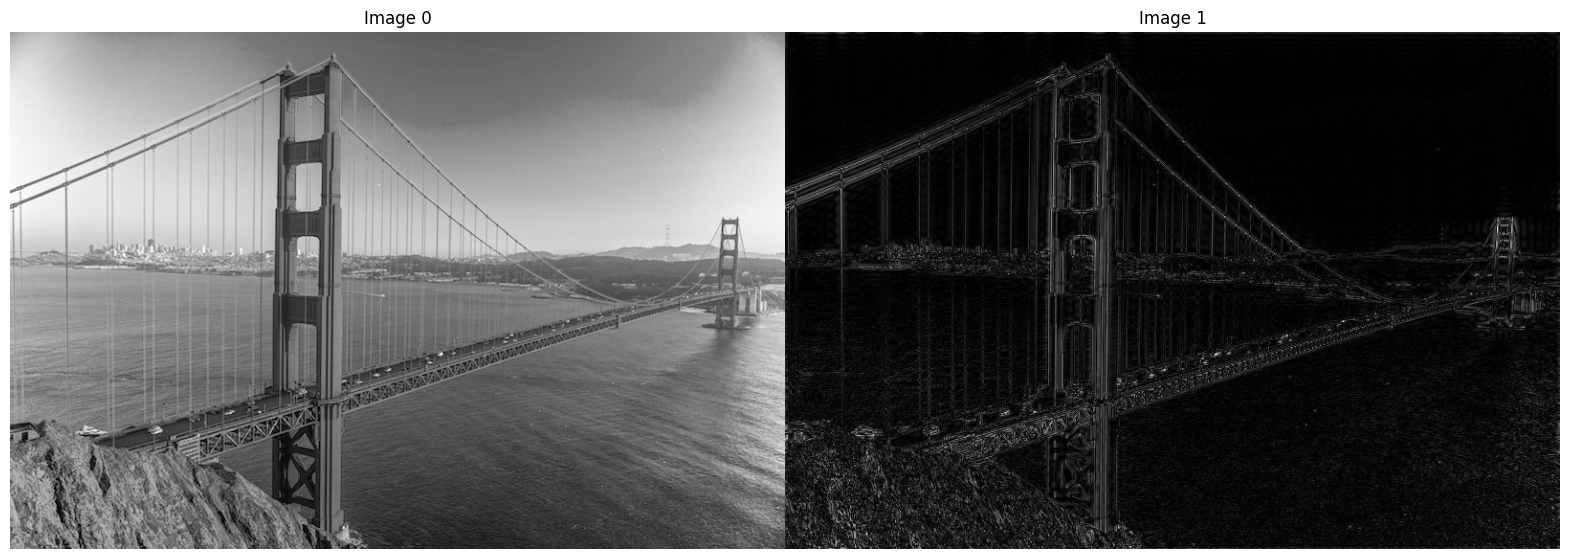

In [ ]:
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros
# mask = np.zeros((rows, cols, 2), np.uint8)
# size = 50
# mask[crow-size:crow+size, ccol-size:ccol+size] = 1
# image_dft_frequency_crop = image_dft_frequency* mask[:,:,0]

image_dft_frequency_crop,mask = ApplyCenterSquareMask2(image_dft_frequency,size = 50,dim = 0)

# apply mask and inverse DFT
# fshift = dft_shift*mask
# f_ishift = np.fft.ifftshift(fshift)
# img_inverse = cv2.idft(f_ishift)
# image_inverse = cv2.magnitude(img_inverse[:,:,0],img_inverse[:,:,1])

image_inverse = InverseDFTWithMask(dft_shift, mask)

ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

 # Theory Exercise

1) Explain the relationship between the spatial domain and the frequency domain in image processing.

2) List and explain the fundamental properties of the 2D Fourier Transform, including linearity, symmetry, shifting, and convolution.

3) Write the formula for the 2D Discrete Fourier Transform (DFT) of an image $ f(x, y) $ with dimensions $ M \times N $.  

4) Explain why, after performing the DFT, the low-frequency components are concentrated in the top-left corner of the frequency spectrum. How can the low-frequency components be shifted to the center?

5) Explain the significance of low-pass filters and high-pass filters in the frequency domain.  

6) For an image $ f(x, y) $, write the formula to apply a circular low-pass filter with a radius $ R $ in the frequency domain.

7) Describe a practical application of the Fourier Transform in image processing.

8) Define the Inverse Fourier Transform and write its mathematical formula.  

9) Given an image with a frequency spectrum $ F(u, v) $, explain how to reconstruct the original image $ f(x, y) $.

10) In the Fourier spectrum $ F(u, v) $, what is the significance of the phase and the magnitude?





#Practical Excise

- Convert the image to grayscale
- Perform DFT and display the image in the frequency domain
- Create a mask to remove the high-frequency domain and display the texture image.
- Create a mask to remove the low-frequency domain and display the edge image
-Create a circular mask with a radius $ r $, then apply it to the frequency domain as described above and output the resulting image.

